In [3]:
import numpy as np
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt

from scipy.special import binom

import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

%matplotlib inline

In [4]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [5]:
def lower_idx(S):
    return set(j for j in range(0, min(S))) | S

def higher_idx(S, n):
    return set(j for j in range(max(S), n)) | S

def neighbours(G, S):
    neigs = set()
    for node in S:
        neigs |= G['neig'][node]
    neigs -= S
    return neigs

def maximal(G, S, P):
    T = {P}
    while True:
        N = neighbours(G, T) & S
        if not N:
            break
        else:
            T |= N
    return T

def connected(G, S):
    return maximal(G, S, min(S)) == S

def enumerate_csg(G):
    subsets = [{i} for i in range(G['n']-1, -1, -1)]
    for subset in subsets:
        yield subset
        yield from enumerate_csg_rec(G, subset, lower_idx(subset))

def enumerate_csg_rec(G, S, X):
    N = neighbours(G, S) - X
    subsets = [set(subset) for subset in powerset(N) if subset]
    for subset in subsets:
        yield S|subset
    for subset in subsets:
        yield from enumerate_csg_rec(G, S|subset, X|N)

def enumerate_cmp(G, S):
    X = lower_idx(S) | S
    N = neighbours(G, S) - X
    subsets = [{v} for v in sorted(N, reverse=True)]
    for subset in subsets:
        yield subset
        yield from enumerate_csg_rec(G, subset, X|(lower_idx(subset)&N))


In [6]:
def gen_graph_star(n):
    G = {'n': n, 'neig': []}
    for i in range(n):
        if i == 0:
            G['neig'].append({j for j in range(1,n)})
        else:
            G['neig'].append({0,})
    return G

def gen_graph_chain(n):
    G = {'n': n, 'neig': []}
    for i in range(n):
        if i == 0:
            G['neig'].append({1})
        elif i == n-1:
            G['neig'].append({n-2})
        else:
            G['neig'].append({i-1,i+1})
    return G

def gen_graph_clique(n):
    G = {'n': n, 'neig': []}
    for i in range(n):
        G['neig'].append(set(j for j in range(n) if j != i))
    return G

def gen_graph_bintree(n):
    G = {'n': n, 'neig': []}
    for i in range(n):
        node = i + 1
        parent = node >> 1
        child1 = node << 1
        child2 = child1 + 1
        neig = set()
        if node != 1:
            neig.add(parent-1)
        if child1 <= n:
            neig.add(child1-1)
        if child2 <= n:
            neig.add(child2-1)
        G['neig'].append(neig)
    return G

In [7]:
def get_sizes_freqs(G, eq_class, max_jobs):
    depbuf = np.zeros(G['n']+1)
    count = 0
    sizes = []
    for S in enumerate_csg(G):
        for Sc in enumerate_cmp(G, S):
            depbuf[eq_class(S,Sc)] += 1
            count += 1 
            if count >= max_jobs:
                sizes += [i for i in depbuf if i != 0]
                depbuf = np.zeros(G['n']+1)
                count = 0

    sizes += [i for i in depbuf if i != 0]
    return sizes

def srqs(S1, S2):
    return len(S1)+len(S2)

def slqs(S1, S2):
    return max(len(S1),len(S2))

In [16]:
G = {
    'n': 9,
    'neig': [
        {1,2},
        {0,3},
        {0,3},
        {1,2,4},
        {3,8},
        {6,8},
        {5,7},
        {6,8},
        {4,5,7}
    ]
}

n = 0
for S in enumerate_csg(G):
    for Sc in enumerate_cmp(G, S):
        if len(S | Sc) == G['n']:
            print(S, Sc)
            n += 1
print(n)

{0} {1, 2, 3, 4, 5, 6, 7, 8}
{0, 1} {2, 3, 4, 5, 6, 7, 8}
{0, 2} {1, 3, 4, 5, 6, 7, 8}
{0, 1, 2} {3, 4, 5, 6, 7, 8}
{0, 1, 3, 4, 5, 6, 7, 8} {2}
{0, 2, 3, 4, 5, 6, 7, 8} {1}
{0, 1, 2, 3} {4, 5, 6, 7, 8}
{0, 1, 2, 3, 4} {8, 5, 6, 7}
{0, 1, 2, 3, 4, 8} {5, 6, 7}
{0, 1, 2, 3, 4, 5, 8} {6, 7}
{0, 1, 2, 3, 4, 7, 8} {5, 6}
{0, 1, 2, 3, 4, 5, 7, 8} {6}
{0, 1, 2, 3, 4, 5, 6, 8} {7}
{0, 1, 2, 3, 4, 6, 7, 8} {5}
14


In [6]:
def calculate_parallelism(G, eq_class, max_jobs, n_parallel):
    sizes = get_sizes_freqs(G, eq_class, max_jobs)
    n_iters = sum((s+n_parallel-1)//n_parallel for s in sizes)
    return sum(sizes)/n_iters

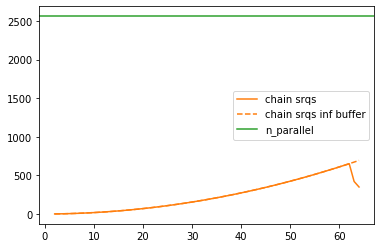

In [51]:
n_parallel = 2560
max_jobs = n_parallel*16
x = list(range(2,65))

# y_star = Parallel(n_jobs=num_cores)(delayed(calculate_parallelism)(gen_graph_star(i), srqs, max_jobs, n_parallel) for i in x)
y_chain = Parallel(n_jobs=num_cores)(delayed(calculate_parallelism)(gen_graph_chain(i), srqs, max_jobs, n_parallel) for i in x)
# plt.plot(x, y_star, label="star srqs", color="C0", linestyle="-")
plt.plot(x, y_chain, label="chain srqs", color="C1", linestyle="-")

y_chain_inf = Parallel(n_jobs=num_cores)(delayed(calculate_parallelism)(gen_graph_chain(i), srqs, np.inf, n_parallel) for i in x)
plt.plot(x, y_chain_inf, label="chain srqs inf buffer", color="C1", linestyle="--")

# y_star = Parallel(n_jobs=num_cores)(delayed(calculate_parallelism)(gen_graph_star(i), slqs, max_jobs, n_parallel) for i in x)
# y_chain = Parallel(n_jobs=num_cores)(delayed(calculate_parallelism)(gen_graph_chain(i), slqs, max_jobs, n_parallel) for i in x)
# plt.plot(x, y_star, label="star slqs", color="C0", linestyle="--")
# plt.plot(x, y_chain, label="chain slqs", color="C1", linestyle="--")

plt.axhline(n_parallel, label="n_parallel", color="C2")
plt.legend()

In [6]:
def enumerate_sub_csg(G, T, I, E):
    if I:
        subsets = [{min(I)}]
    else:
        subsets = [{i} for i in T-E]
    for subset in subsets:
        if subset >= I:
            yield subset
        yield from enumerate_sub_csg_rec(G, subset, lower_idx(subset), T, I-subset, E)

def enumerate_sub_csg_rec(G, S, X, T, I, E):
    N = (neighbours(G, S) - X) & (T-E)

    if I and min(I) in N:
        N = {min(I)}

    subsets = [set(subset) for subset in powerset(N) if subset]
    for subset in subsets:
        if subset >= I:
            yield S|subset
        yield from enumerate_sub_csg_rec(G, S|subset, X|N, T, I-subset, E)

In [7]:
def enumerate_sub_csg_stack(G, T, I, E):
    max_stack = 0
    stack = []
    if I:
        stack += [({min(I)}, lower_idx({min(I)}))]
    else:
        stack += [({i}, lower_idx({i})) for i in T-E]

    while stack:
        max_stack = max(max_stack, len(stack))
        S, X = stack.pop()
        if I <= S:
            yield S
        
        N = (neighbours(G, S) - X) & (T-E)

        if (I-S) and min(I-S) in N:
            N = {min(I-S)}

        stack += [(S|set(subset), X|N) for subset in powerset(N) if subset]

    return max_stack

def next_subset(subset, N):
    subsets = list(set(subset) for subset in powerset(N))
    try:
        return set(subsets[subsets.index(subset)+1])
    except:
        return set()


def enumerate_sub_csg_short_stack(G, T, I, E):
    max_stack = 0
    stack = []
    
    if I:
        stack += [({min(I)}, set(), lower_idx({min(I)}), set())]
    else:
        stack += [({i}, set(), lower_idx({i}), set()) for i in T-E]

    while stack:
        max_stack = max(max_stack, len(stack))

        S, subset, X, N = stack.pop()
        
        if not subset and I <= S:
            yield S

        if not N:
            N = (neighbours(G, S) - X) & (T-E)

            if (I-S) and min(I-S) in N:
                N = {min(I-S)}

        subset = next_subset(subset, N)
        if subset:
            stack.append((S, subset, X, N))
            stack.append((S|subset, set(), X|N, set()))

    return max_stack

def enumerate_sub_csg_short_multi_stack(G, T, I, E):
    max_stack = 0
    emit_stack = []
    loop_stack = []
    if I:
        emit_stack += [({min(I)}, lower_idx({min(I)}))]
    else:
        emit_stack += [({i}, lower_idx({i})) for i in T-E]

    while emit_stack or loop_stack:
        max_stack = max(max_stack, len(emit_stack), len(loop_stack))

        if emit_stack:
            S, X = emit_stack.pop()
        
            if I <= S:
                yield S

            N = (neighbours(G, enumerate_sub_csg_short_stack_unrolledS) - X) & (T-E)

            if (I-S) and min(I-S) in N:
                N = {min(I-S)}

            loop_stack.append((S, set(), X, N))

        if loop_stack:
            S, subset, X, N = loop_stack.pop()
            subset = next_subset(subset, N)

            if subset:
                loop_stack.append((S, subset, X, N))
                emit_stack.append((S|subset, X|N))

    return max_stack

def enumerate_sub_csg_short_stack_unrolled(G, T, I, E):
    max_stack = 0
    loop_stack = []

    if I:
        loop_stack += [(set(), lower_idx({min(I)}), {min(I)})]
    else:
        loop_stack += [(set(), lower_idx({i}), {i}) for i in T-E]

    while loop_stack:
        max_stack = max(max_stack, len(loop_stack))

        S, X, N = loop_stack.pop()
        subset = next_subset(S&N, N)
        emit_S = (S-N)|subset
        
        if subset and I <= emit_S:
            yield emit_S

        if subset:
            loop_stack.append((emit_S, X, N))

            emit_X = X|N
            N = (neighbours(G, emit_S) - emit_X) & (T-E)

            if (I-emit_S) and min(I-emit_S) in N:
                N = {min(I-emit_S)}

            if N:
                loop_stack.append((emit_S, emit_X, N))

    return max_stack

In [8]:
def enumerate_sub_cst(G, T, I, E):
    if I:
        roots = [i for i in I]
    else:
        roots = [i for i in T]

    for root in roots:
        S = {root}
        yield from enumerate_sub_cst_rec(G, S, lower_idx(S), T)

def enumerate_sub_cst_rec(G, S, X, T):
    N = (neighbours(G, S) & T) - X
    if N:
        S1 = S|N
        X1 = X|N
        yield from enumerate_sub_cst_rec(G, S1, X1, T)
    else:
        yield S
        

In [9]:
class Generator:
    def __init__(self, gen):
        self.gen = gen

    def __iter__(self):
        self.value = yield from self.gen

def collect_all_subs(G, T, I, E):
    l = []
    gen = Generator(enumerate_sub_csg_short_stack_unrolled(G, T, I, E))
    for S in gen:
        l.append(tuple(sorted(S)))
    return l, gen.value

In [62]:
N = 10
G = gen_graph_star(N)
# G = {
#     'n': 5,
#     'neig': [
#         {2},
#         {3},
#         {0,3,4},
#         {1,2,4},
#         {2,3}
#     ]
# }
# T = {0,1,2}
# R = {0}
# K = len(T)

K = 5
T = set(range(K))
R = set()

max_stack = 0
n_subs = 0
Is = [set(subset) for subset in powerset(R)]
                                                                                                                                                            
parallel_ret = Parallel(n_jobs=num_cores)(delayed(collect_all_subs)(G, T, I, R-I) for I in Is)
all_subs = [subs for subs, max_stack in parallel_ret]

print("max_stack:", max(max_stack for subs, max_stack in parallel_ret))

all_subs_set = set()
n_gen_subs = 0
for l in all_subs:
    for t in l:
        if t in all_subs_set:
            print("Warning: duplicate tuple", t)
        all_subs_set.add(t)
        n_gen_subs += 1

all_valid_subs = {tuple(sorted(S)) for S in enumerate_sub_csg(G, T, set(), set())}

if not (all_subs_set >= all_valid_subs):
    missing = all_valid_subs-all_subs_set
    if len(missing) < 10:
        print("Error: missing", len(missing), "subsets", missing)
    else:
        print("Error: missing", len(missing), "subsets")

print("n_sets:", int(binom(N,K)))
print("n_unique_subs:", len(all_subs_set))
print("n_gen_subs:", n_gen_subs)
print("n_valid_subs:", len(all_valid_subs))
print("n_all_subs:", 2**len(T)-2)

max_stack: 5
n_sets: 252
n_unique_subs: 20
n_gen_subs: 20
n_valid_subs: 20
n_all_subs: 30


In [10]:
def get_n_pairs(G):
    from scipy.special import binom

    n_gen_pairs = 0
    n_gen_conn_pairs = 0
    for subset in powerset(set(range(G['n']))):
        T = set(subset)
        if len(subset) >= 2:
            all_valid_subs = {tuple(sorted(S)) for S in enumerate_sub_csg(G, T, set(), set())}
            n_gen_pairs += len(all_valid_subs)
            if connected(G, T):
                n_gen_conn_pairs += len(all_valid_subs)
                #print(subset, all_valid_subs)
    
    n_cst_pairs = 0
    for subset in powerset(set(range(G['n']))):
        T = set(subset)
        if len(subset) >= 2:
            if connected(G, T):
                all_valid_subs = {tuple(sorted(S)) for S in enumerate_sub_cst(G, T, set(), set())}
                n_cst_pairs += len(all_valid_subs)
                #print(subset, all_valid_subs)

    subsets = set()
    sizes = [0] * G['n']
    sizes[0] = G['n']
    n_valid_pairs = 0
    for S in enumerate_csg(G):
        for Sc in enumerate_cmp(G, S):
            key = tuple(S|Sc)
            if key not in subsets:
                sizes[len(S|Sc)-1] += 1
                subsets.add(key)
            n_valid_pairs += 1

    n_dpsize_pairs = 0
    for s in range(2,G['n']+1):
        for i in range(1, s):
            n_dpsize_pairs += sizes[i-1] * sizes[s-i-1]

    n_dpsub_pairs = 0
    for i in range(2,G['n']+1):
        n_dpsub_pairs += int(binom(G['n'],i)) * (2**i-2)

    n_dpsub_conn_pairs = 0
    for i in range(2,G['n']+1):
        n_dpsub_conn_pairs += sizes[i-1] * (2**i-2)

    return n_valid_pairs, n_dpsize_pairs, n_dpsub_pairs, n_dpsub_conn_pairs, n_gen_pairs, n_gen_conn_pairs, n_cst_pairs

def pairs_to_size(n_pairs):
    unit = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    unit_idx = 0
    n_bytes = n_pairs * 16
    while n_bytes > 1024:
        n_bytes /= 1024
        unit_idx += 1
    return f"{n_bytes:.2f}{unit[unit_idx]}"

In [11]:
def get_n_subgraphs(G):
    return sum(1 for S in enumerate_csg(G))

In [36]:
N = 15
G = gen_graph_star(N)
n_subgraphs = get_n_subgraphs(G)
n_valid_pairs, n_dpsize_pairs, n_dpsub_pairs, n_dpsub_conn_pairs, n_gen_pairs, n_gen_conn_pairs, n_cst_pairs = get_n_pairs(G)
print("n_subgraphs:", n_subgraphs, pairs_to_size(n_subgraphs))
print("n_valid_pairs:", n_valid_pairs, pairs_to_size(n_valid_pairs))
print("n_dpsize_pairs:", n_dpsize_pairs, pairs_to_size(n_dpsize_pairs))
print("n_dpsub_pairs:", n_dpsub_pairs, pairs_to_size(n_dpsub_pairs))
print("n_dpsub_conn_pairs:", n_dpsub_conn_pairs, pairs_to_size(n_dpsub_conn_pairs))
print("n_gen_pairs:", n_gen_pairs, pairs_to_size(n_gen_pairs))
print("n_gen_conn_pairs:", n_gen_conn_pairs, pairs_to_size(n_gen_conn_pairs))
print("n_cst_pairs:", n_cst_pairs, pairs_to_size(n_cst_pairs))

{'n': 20, 'neig': [{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}, {0}]}
n_subgraphs: 524307 8.00MB
n_valid_pairs: 88 1.38KB
n_dpsize_pairs: 852 13.31KB
n_dpsub_pairs: 1932 30.19KB
n_dpsub_conn_pairs: 692 10.81KB
n_gen_pairs: 826 12.91KB
n_gen_conn_pairs: 349 5.45KB
n_cst_pairs: 118 1.84KB


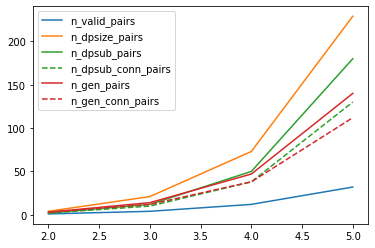

In [13]:
N = 5
parallel_ret = Parallel(n_jobs=num_cores)(delayed(get_n_pairs)(gen_graph_star(n)) for n in range(2,N+1))
series = [[] for i in range(6)]
series_color = ['C0', 'C1', 'C2', 'C2', 'C3', 'C3']
series_linestyle = ['-', '-', '-', '--', '-', '--']
series_label = ["n_valid_pairs", "n_dpsize_pairs", "n_dpsub_pairs", "n_dpsub_conn_pairs", "n_gen_pairs", "n_gen_conn_pairs"]

for r in parallel_ret:
    for i, n in enumerate(r):
        series[i].append(n)

x = list(range(2,N+1))
for i in range(len(series)):
    plt.plot(x, series[i], color=series_color[i], linestyle=series_linestyle[i], label=series_label[i])

#plt.yscale('log')
plt.legend()
plt.show()


In [18]:
pairs_to_size(4980736)

'76.00MB'

In [16]:
# Musicbrainz

G_musicbrainz = {
    'n': 56,
    'neig': [
        {1,2}, #  0
        {0}, #  1
        {0,3,4,5,6,7,8}, #  2
        {2}, #  3
        {2}, #  4
        {2}, #  5
        {2}, #  6
        {2,9,10,11,12,13,14,15,16}, #  7
        {2,17}, #  8
        {7,22}, #  9
        {7,23,24}, # 10
        {7}, # 11
        {7}, # 12
        {7}, # 13
        {7,25,26,27,28,29}, # 14
        {7}, # 15
        {7,30}, # 16
        {8,18,19,20,21}, # 17
        {17,31,32,19}, # 18
        {17,18,30,29,37,38,40,41,42,34}, # 19
        {17,21,34}, # 20
        {17,20,33}, # 21
        {9}, # 22
        {10}, # 23
        {10,35}, # 24
        {14}, # 25
        {14,36}, # 26
        {14}, # 27
        {14}, # 28
        {14,19}, # 29
        {16,19}, # 30
        {18,55}, # 31
        {18}, # 32
        {21}, # 33
        {20,43,19,44}, # 34
        {24}, # 35
        {26}, # 36
        {19}, # 37
        {19,56}, # 38
        set(), # 39
        {19}, # 40
        {19}, # 41
        {19}, # 42
        {34}, # 43
        {34,46}, # 44
        {56,47,48,49,50}, # 45
        {44}, # 46
        {45,51}, # 47
        {45}, # 48
        {45}, # 49
        {45,52,53}, # 50
        {47}, # 51
        {50,53}, # 52
        {50,52}, # 53
        set(), # 54
        {31}, # 55
        {38,45}, # 56
    ],
    'labels': [
        "artist_alias", #  0
        "artist_alias_type", #  1
        "artist", #  2
        "artist_type", #  3
        "artist_ipi", #  4
        "gender", #  5
        "artist_isni", #  6
        "area", #  7
        "artist_credit_name", #  8
        "area_alias", #  9
        "place", # 10
        "iso_3166_1", # 11
        "iso_3166_2", # 12
        "iso_3166_3", # 13
        "label", # 14
        "area_type", # 15
        "country_area", # 16
        "artist_credit", # 17
        "release_group", # 18
        "release", # 19
        "track", # 20
        "recording", # 21
        "area_alias_type", # 22
        "place_type", # 23
        "place_alias", # 24
        "label_type", # 25
        "label_alias", # 26
        "label_isni", # 27
        "label_ipi", # 28
        "release_label", # 29
        "release_country", # 30
        "release_group_secondary_type_join", # 31
        "release_group_primary_type", # 32
        "isrc", # 33
        "medium", # 34
        "place_alias_type", # 35
        "label_alias_type", # 36
        "release_unknown_country", # 37
        "language", # 38
        "script_language", # 39 - no longer exists
        "script", # 40
        "release_packaging", # 41
        "release_status", # 42
        "medium_format", # 43
        "medium_cdtoc", # 44
        "work", # 45
        "cdtoc", # 46
        "work_alias", # 47
        "work_type", # 48
        "iswc", # 49
        "work_attribute", # 50
        "work_alias_type", # 51
        "work_attribute_type_allowed_value", # 52
        "work_attribute_type", # 53
        "url", # 54
        "release_group_secondary_type", # 55
        "work_language" # 56
    ],
    'edge_attributes': [
        {1:('type','id'),2:('artist','id')}, #  0
        {0:('id','type')}, #  1
        {0:('id','artist'),3:('type','id'),4:('id','artist'),5:('gender','id'),6:('id','artist'),7:('area','id'),8:('id','artist')}, #  2
        {2:('id','type')}, #  3
        {2:('artist','id')}, #  4
        {2:('id','gender')}, #  5
        {2:('artist','id')}, #  6
        {2:('id','area'),9:('id','area'),10:('id','area'),11:('id','area'),12:('id','area'),13:('id','area'),14:('id','area'),15:('type','id'),16:('id','area')}, #  7
        {2:('artist','id'),17:('artist_credit','id')}, #  8
        {7:('area','id'),22:('type','id')}, #  9
        {7:('area','id'),23:('type','id'),24:('id','place')}, # 10
        {7:('area','id')}, # 11
        {7:('area','id')}, # 12
        {7:('area','id')}, # 13
        {7:('area','id'),25:('type','id'),26:('id','label'),27:('id','label'),28:('id','label'),29:('id','label')}, # 14
        {7:('id','type')}, # 15
        {7:('area','id'),30:('area','country')}, # 16
        {8:('id','artist_credit'),18:('id','artist_credit'),19:('id','artist_credit'),20:('id','artist_credit'),21:('id','artist_credit')}, # 17
        {17:('artist_credit','id'),31:('id','release_group'),32:('type','id'),19:('id','release_group')}, # 18
        {17:('artist_credit','id'),18:('release_group','id'),30:('id','release'),29:('id','release'),37:('id','release'),38:('language','id'),40:('script','id'),41:('packaging','id'),42:('status','id'),34:('id','release')}, # 19
        {17:('artist_credit','id'),21:('recording','id'),34:('medium','id')}, # 20
        {17:('artist_credit','id'),20:('id','recording'),33:('id','recording')}, # 21
        {9:('id','type')}, # 22
        {10:('id','type')}, # 23
        {10:('place','id'),35:('type','id')}, # 24
        {14:('id','type')}, # 25
        {14:('label','id'),36:('type','id')}, # 26
        {14:('label','id')}, # 27
        {14:('label','id')}, # 28
        {14:('label','id'),19:('release','id')}, # 29
        {16:('country','area'),19:('release','id')}, # 30
        {18:('release_group','id'),55:('secondary_type','id')}, # 31
        {18:('id','type')}, # 32
        {21:('recording','id')}, # 33
        {20:('id','medium'),43:('format','id'),19:('release','id'),44:('id','medium')}, # 34
        {24:('id','type')}, # 35
        {26:('id','type')}, # 36
        {19:('release','id')}, # 37
        {19:('id','language'),56:('id','language')}, # 38
        {}, # 39
        {19:('id','script')}, # 40
        {19:('id','packaging')}, # 41
        {19:('id','status')}, # 42
        {34:('id','format')}, # 43
        {34:('medium','id'),46:('cdtoc','id')}, # 44
        {56:('id','work'),47:('id','work'),48:('type','id'),49:('id','work'),50:('id','work')}, # 45
        {44:('id','cdtoc')}, # 46
        {45:('work','id'),51:('type','id')}, # 47
        {45:('id','type')}, # 48
        {45:('work','id')}, # 49
        {45:('work','id'),52:('work_attribute_type_allowed_value','id'),53:('work_attribute_type','id')}, # 50
        {47:('id','type')}, # 51
        {50:('id','work_attribute_type_allowed_value'),53:('work_attribute_type','id')}, # 52
        {50:('id','work_attribute_type'),52:('id','work_attribute_type')}, # 53
        {}, # 54
        {31:('id','secondary_type')}, # 55
        {45:('work','id'),38:('language','id')}, # 56
    ]
}

# check bidirectionality
for i,neig in enumerate(G_musicbrainz['neig']):
    for j in neig:
        try:
            assert(i in G_musicbrainz['neig'][j])
            assert(G_musicbrainz['edge_attributes'][i][j][0] == G_musicbrainz['edge_attributes'][j][i][1])
            assert(G_musicbrainz['edge_attributes'][i][j][1] == G_musicbrainz['edge_attributes'][j][i][0])
        except:
            print(i,j)
            raise
print("OK")


OK


In [12]:
from random import choice, randint, shuffle

def gen_random_query(G, N):
    neigs = set(range(G['n']))
    queryset = set()
    from_clauses = []
    where_clauses = []

    G_out = {'n': N, 'neig': [set() for i in range(N)]}
    remapping = {}

    n = 0
    while len(queryset) < N:
        if not neigs:
            break

        node = choice(tuple(neigs))
        remapping[node] = n

        if queryset:
            peers = [n for n in queryset if n in G['neig'][node]]
            shuffle(peers)
            for i in range(randint(1,len(peers))):
                peer = peers[i]
                edge = G['edge_attributes'][peer][node]
                where_clauses.append(f"\"{G['labels'][peer]}\".\"{edge[0]}\" = \"{G['labels'][node]}\".\"{edge[1]}\"")
                G_out['neig'][remapping[node]].add(remapping[peer])
                G_out['neig'][remapping[peer]].add(remapping[node])

        queryset.add(node)
        from_clauses.append(G['labels'][node])
        neigs = neighbours(G, queryset)

        n += 1
    
    if len(queryset) < N:
        # print(f"No more neighbors at size {len(queryset)}, retrying")
        return gen_random_query(G, N)
    else:
        from_clause = '", "'.join(from_clauses)
        where_clause = ' AND '.join(where_clauses)
        return G_out, f"SELECT * FROM \"{from_clause}\" WHERE {where_clause};"

In [23]:
G, query = gen_random_query(G_musicbrainz, 10)
print(query)
print(G)
n_valid_pairs, n_dpsize_pairs, n_dpsub_pairs, n_dpsub_conn_pairs, n_gen_pairs, n_gen_conn_pairs = get_n_pairs(G)
print("n_valid_pairs:", n_valid_pairs, pairs_to_size(n_valid_pairs))
print("n_dpsize_pairs:", n_dpsize_pairs, pairs_to_size(n_dpsize_pairs))
print("n_dpsub_pairs:", n_dpsub_pairs, pairs_to_size(n_dpsub_pairs))
print("n_dpsub_conn_pairs:", n_dpsub_conn_pairs, pairs_to_size(n_dpsub_conn_pairs))
print("n_gen_pairs:", n_gen_pairs, pairs_to_size(n_gen_pairs))
print("n_gen_conn_pairs:", n_gen_conn_pairs, pairs_to_size(n_gen_conn_pairs))

SELECT * FROM "cdtoc", "medium_cdtoc", "medium", "track", "recording", "artist_credit", "release", "script", "release_label", "release_country" WHERE "cdtoc"."id" = "medium_cdtoc"."cdtoc" AND "medium_cdtoc"."medium" = "medium"."id" AND "medium"."id" = "track"."medium" AND "track"."id" = "recording"."recording" AND "track"."artist_credit" = "artist_credit"."id" AND "medium"."release" = "release"."id" AND "release"."script" = "script"."id" AND "release"."id" = "release_label"."release" AND "release"."id" = "release_country"."release";
{'n': 10, 'neig': [{1}, {0, 2}, {1, 3, 6}, {2, 4, 5}, {3}, {3}, {8, 9, 2, 7}, {6}, {6}, {6}]}
n_valid_pairs: 668 10.44KB
n_dpsize_pairs: 11381 177.83KB
n_dpsub_pairs: 57002 890.66KB
n_dpsub_conn_pairs: 14424 225.38KB
n_gen_pairs: 11827 184.80KB
n_gen_conn_pairs: 4192 65.50KB


In [82]:
def get_gen_valid_ratio(n):
    G, query = gen_random_query(G_musicbrainz, n)
    n_valid_pairs, n_dpsize_pairs, n_dpsub_pairs, n_dpsub_conn_pairs, n_gen_pairs, n_gen_conn_pairs = get_n_pairs(G)
    return n, n_gen_conn_pairs/n_valid_pairs

N = 20
R = 3

results = Parallel(n_jobs=num_cores)(delayed(get_gen_valid_ratio)(n) for n in range(2,N+1) for i in range(R))

x = [r[0] for r in results]
y = [r[1] for r in results]

plt.scatter(x, y)

KeyboardInterrupt: 

In [15]:
import string
labels = [f"{a}{b}" for a in string.ascii_lowercase for b in string.ascii_lowercase]
for n in range(33,65):
    for i in range(15):
        G, query = gen_random_query(G_musicbrainz, n)
        with open(f"musicbrainz/queries/{n:02d}{labels[i]}.sql", 'w') as f:
            f.write(query)
            f.write("\n")

RecursionError: maximum recursion depth exceeded while calling a Python object

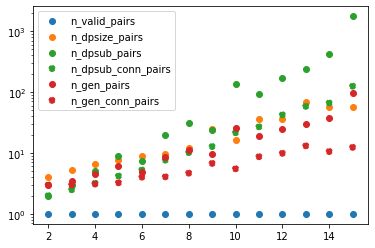

In [15]:
N = 15
R = 1
parallel_ret = Parallel(n_jobs=num_cores)(delayed(get_n_pairs)(gen_random_query(G_musicbrainz, n)[0]) for n in range(2,N+1) for r in range(R))
series = [[] for i in range(6)]
series_color = ['C0', 'C1', 'C2', 'C2', 'C3', 'C3']
series_linestyle = ['-', '-', '-', '--', '-', '--']
series_label = ["n_valid_pairs", "n_dpsize_pairs", "n_dpsub_pairs", "n_dpsub_conn_pairs", "n_gen_pairs", "n_gen_conn_pairs"]

for r in parallel_ret:
    for i, n in enumerate(r):
        series[i].append(n)

x = list(range(2,N+1))
for i in range(len(series)):
    if series_label[i] in ["n_dpsize_pairs", "n_dpsub_conn_pairs", "n_gen_conn_pairs"]:
        plt.scatter(x, np.array(series[i])/np.array(series[0]), color=series_color[i], linestyle=series_linestyle[i], label=series_label[i])

plt.yscale('log')
plt.legend()
plt.show()

# linearizedDP

In [34]:
class IKKBZRel:
    def __init__(self, idx, sel, rows):
        self.idx = idx
        self.sel = sel
        self.rows = rows

    def __str__(self):
        return str(self.idx+1)

class IKKBZNode:
    def __init__(self, rels, T, C):
        self.children = []
        self.rels = rels
        self.T = T
        self.C = C
    
    def next(self):
        return self.children[0] if self.children else None
    
    def n_children(self):
        return len(self.children)

    def rank(self):
        if self.C:
            return (self.T-1)/self.C
        else:
            return 0
    
    def __str__(self):
        return ','.join(map(str, self.rels))

def print_tree_rec(node, prefix='', new_row=True, last_row=False):
    if new_row and prefix:
        print()
        print(prefix[:-1], end='')
        print('└' if last_row else '├', end='')
    
    if prefix:
        this_print  = '──' + str(node)
    else:
        this_print = str(node)

    print(this_print, end='')
    
    add_row = False
    for child in node.children:
        new_last_row = child == node.children[-1]
        new_prefix = (
            (prefix + '' if new_last_row else '|') +
            ' ' * (len(this_print)-1) + 
            ('|' if not new_last_row
                else ' ')
        )
        print_tree_rec(child, new_prefix, add_row, new_last_row)
        add_row = True

def print_tree(node):
    print_tree_rec(node)
    print()
    

def extract_rels(G):
    rels = []
    for i in range(G['n']):
        rels.append(IKKBZRel(i, np.nan, G['rows'][i]))
    return rels

def graph_to_tree(G, root):
    rels = extract_rels(G)
    root_node = IKKBZNode([rels[root]], rels[root].rows, 0)

    stack = [(root_node, None)]

    while stack:
        node, parent = stack.pop()
        
        for n in G['neig'][node.rels[0].idx]:
            if parent and n == parent.rels[0].idx:
                continue
            
            rels[n].sel = G['sels'][node.rels[0].idx][n]
            c = rels[n].sel * rels[n].rows
            new_node = IKKBZNode([rels[n]], c, c)
            node.children.append(new_node)
            print("Added child to %d: %d (c=%f)" % (node.rels[0].idx, new_node.rels[0].idx, c))
            stack.append((new_node, node))

    return root_node

def find_node_with_chain_children(node):
    if node.n_children() == 0:
        print(node, "has no children")
        return None
    elif node.n_children() == 1:
        return find_node_with_chain_children(node.next())
    else:
        for child in node.children:
            ret = find_node_with_chain_children(child)
            if ret:
                print(child, "child of", node, "has non-chain subtree: ", ret)
                return ret
        print("subtree rooted in ", node, "is a non-chain subtree")
        return node

def merge_nodes(node1, node2):
    print("merging", node1, "and", node2)
    node1.C += node1.T * node2.C
    node1.T *= node2.T
    node1.rels += node2.rels
    node1.children = node2.children
    print("merge result: ", node1, node1.C, node1.T)

def IKKBZ_normalize(root):
    print("normalizing")
    print_tree(root)
    node = root
    prev = None
    
    while node:
        if prev:
            if prev.rank() > node.rank():
                merge_nodes(prev, node)
                node = prev.next()
                continue
            else:
                print("rank(%s) = %f < rank(%s) = %f" %(
                    prev, prev.rank(),
                    node, node.rank()
                ))
        prev = node
        node = node.next()

    print("normalization result")
    print_tree(root)

def IKKBZ_merge(chains):
    print("merging chains")
    for ch in chains:
        print("subtree:", end='')
        print_tree(ch)

        node = ch
        print("C:", end='')
        while node:
            print(node.C, end='')
            node = node.next()
        print()

        node = ch
        print("T:", end='')
        while node:
            print(node.T, end='')
            node = node.next()
        print()

        node = ch
        print("rank:", end='')
        while node:
            print(node.rank(), end='')
            node = node.next()

    root = None
    node = None

    while any(chains):
        amin = -1
        for i, ch in enumerate(chains):
            if not ch:
                continue
            if amin < 0 or ch.rank() < chains[amin].rank():
                amin = i
        if node:
            node.children = [chains[amin]]
        else:
            root = chains[amin]

        node = chains[amin]
        chains[amin] = node.next()

    print("merged chains")
    print_tree(root)
    return root

def chain_to_list(node):
    ret = []

    while node:
        ret += [e.idx for e in node.rels]
        node = node.next()
    
    return ret

def IKKBZ_iter(G, root_id):
    v = graph_to_tree(G, root_id)

    print("IKKBZ_iter", root_id)
    print_tree(v)

    while True:
        v_prime = find_node_with_chain_children(v)

        if v_prime == None:
            break

        print("iter %d: %s: before" % (root_id, v))
        print_tree(v_prime)

        for child in v_prime.children:
            IKKBZ_normalize(child)
        
        v_prime.children = [IKKBZ_merge(v_prime.children)]

        print("iter %d: %s: after" % (root_id, v))
        print_tree(v_prime)

    print_tree(v)
    print("rank: ")
    
    return v

In [35]:
def baserel(i, G):
    return {
            "rels": [i],
            "rows": G["rows"][i],
            "cost": 0,
            "left": None,
            "right": None
    }

def all_edges(rels, G):
    for rel in rels:
        yield from G['neig'][rel]

def can_join(l, r, G):
    l_edges = set(all_edges(l["rels"], G))
    return any(rel in l_edges for rel in r["rels"])

def join_size(l, r, G):
    sel = 1
    for i in l['rels']:
        for j in G['neig'][i]:
            if j in r["rels"]:
                sel *= G['sels'][i][j]
    return sel * l['rows'] * r['rows']

def join(l, r, G):
    rows = join_size(l, r, G)
    return {
        "rels": l["rels"] + r["rels"],
        "rows": rows,
        "cost": rows + l["cost"] + r["cost"],
        "left": l,
        "right": r
    }
    
def cout_left_deep_tree(G, o):
    rels = [baserel(i, G) for i in range(G['n'])]
    joinrel = rels[o[0]]
    for r in o[1:]:
        if any(rel_l in G['neig'][r] for rel_l in joinrel['rels']):
            joinrel = join(joinrel, rels[r], G)
        else:
            return np.inf
    return joinrel['cost']

def chain_to_cost(chain):
    node = chain
    prev = None

    while node:
        if prev:
            merge_nodes(prev, node)
            node = prev.next()
        else:
            prev = node
            node = node.next()
    return prev.C

def IKKBZ(G):
    b = []
    cost_b = np.inf

    for v_id in range(G['n']):
        v = IKKBZ_iter(G, v_id)
        o = chain_to_list(v)
        c = cout_left_deep_tree(G, o)
        c2 = chain_to_cost(v)
        print("Tree rooted in ", v_id, ":", c, c2, o)
        if not b or c < cost_b:
            b = o
            cost_b = c
        
    return b

def linearizedDP(G, remap=None):
    if not remap:
        remap = IKKBZ(G)

    print("Run DP using order: ", remap)
    T = [[None] * G['n'] for _ in range(G['n'])]

    for i in range(G['n']):
        T[i][i] = baserel(remap[i], G)

    for s in range(2, G['n']+1):
        for i in range(0, G['n']-s+1):
            for j in range(1, s):
                print(f"{s}/{G['n']}", i, j, ":", i, i+j-1, "|", i+j, i+s-1)
                l = T[i][i+j-1]
                r = T[i+j][i+s-1]
                if not l or not r:
                    print("Invalid l or r")
                    continue
                if can_join(l, r, G):
                    print("Try join  ", l["rels"], r["rels"])
                    p = join(l, r, G)
                    if not T[i][i+s-1] or p["cost"] < T[i][i+s-1]["cost"]:
                        T[i][i+s-1] = p
                else:
                    print("Can't join", l["rels"], r["rels"])

    return T[0][G['n']-1]

def print_query(q, indent=0):
    if q == None:
        return

    print(f"{'   '*indent}{q['rels']} (rows={q['rows']} cost={q['cost']})")
    print_query(q['left'], indent+1)
    print_query(q['right'], indent+1)



In [79]:
G = {
    'n': 5,
    'neig': [
        [1, 2],
        [0],
        [0,3,4],
        [2],
        [2]
    ],
    'sels': [
        [  0, 1/5, 1/3,   1,   1],
        [1/5,   0,   1,   1,   1],
        [1/3,   1,   0,1/10,   1],
        [  1,   1,1/10,   0,   1],
        [  1,   1,   1,   1,   0]
    ],
    'rows': [
        10,
        20,
        30,
        50,
        20
    ]
}

# print(','.join(map(str, chain_to_list(IKKBZ_iter(G, 0)))))
# print(','.join(map(str, IKKBZ(G))))
res = linearizedDP(G)
print_query(res)

Added child to 0: 1 (c=4.000000)
Added child to 0: 2 (c=10.000000)
Added child to 2: 3 (c=5.000000)
Added child to 2: 4 (c=20.000000)
IKKBZ_iter 0
1──2
└──3──4
   └──5
2 has no children
4 has no children
5 has no children
subtree rooted in  3 is a non-chain subtree
3 child of 1 has non-chain subtree:  3
iter 0: 1: before
3──4
└──5
normalizing
4
normalization result
4
normalizing
5
normalization result
5
merging chains
subtree:4
C:5.0
T:5.0
rank:0.8subtree:5
C:20
T:20
rank:0.95merged chains
4──5
iter 0: 1: after
3──4──5
2 has no children
5 has no children
subtree rooted in  1 is a non-chain subtree
iter 0: 1: before
1──2
└──3──4──5
normalizing
2
normalization result
2
normalizing
3──4──5
merging 3 and 4
merge result:  3,4 60.0 50.0
rank(4) = 0.800000 < rank(5) = 0.950000
normalization result
3,4──5
merging chains
subtree:2
C:4.0
T:4.0
rank:0.75subtree:3,4──5
C:60.020
T:50.020
rank:0.81666666666666670.95merged chains
2──3,4──5
iter 0: 1: after
1──2──3,4──5
5 has no children
1──2──3,4──5


In [80]:
G = {
    'n': 9,
    'neig': [
        [2],
        [2],
        [0,1,3],
        [2, 4],
        [3, 5, 7],
        [4, 6],
        [5],
        [4, 8],
        [7],
    ],
    'sels': [
        [   0,   1, 1/6,   1,   1,   1,   1,   1,   1],
        [   1,   0,1/10,   1,   1,   1,   1,   1,   1],
        [ 1/6,1/10,   0,1/20,   1,   1,   1,   1,   1],
        [   1,   1,1/20,   0, 3/4,   1,   1,   1,   1],
        [   1,   1,   1, 3/4,   0, 1/2,   1, 1/5,   1],
        [   1,   1,   1,   1, 1/2,   0,1/14,   1,   1],
        [   1,   1,   1,   1,   1,1/14,   0,   1,   1],
        [   1,   1,   1,   1, 1/5,   1,   1,   0,1/25],
        [   1,   1,   1,   1,   1,   1,   1,1/25,   0]
    ],
    'rows': [
        30,
        100,
        30,
        20,
        10,
        20,
        70,
        100,
        100
    ]
}

# print(','.join(map(str, chain_to_list(IKKBZ_iter(G, 0)))))
res = linearizedDP(G)
print_query(res)

 8 (c=4.000000)
Added child to 5: 6 (c=5.000000)
IKKBZ_iter 0
1──3──2
   └──4──5──6──7
         └──8──9
2 has no children
7 has no children
9 has no children
subtree rooted in  5 is a non-chain subtree
4 child of 3 has non-chain subtree:  5
iter 0: 1: before
5──6──7
└──8──9
normalizing
6──7
merging 6 and 7
merge result:  6,7 60.0 50.0
normalization result
6,7
normalizing
8──9
merging 8 and 9
merge result:  8,9 100.0 80.0
normalization result
8,9
merging chains
subtree:6,7
C:60.0
T:50.0
rank:0.8166666666666667subtree:8,9
C:100.0
T:80.0
rank:0.79merged chains
8,9──6,7
iter 0: 1: after
5──8,9──6,7
2 has no children
6,7 has no children
subtree rooted in  3 is a non-chain subtree
iter 0: 1: before
3──2
└──4──5──8,9──6,7
normalizing
2
normalization result
2
normalizing
4──5──8,9──6,7
rank(4) = 0.000000 < rank(5) = 0.866667
merging 5 and 8,9
merge result:  5,8,9 757.5 600.0
rank(8,9) = 0.790000 < rank(6,7) = 0.816667
normalization result
4──5,8,9──6,7
merging chains
subtree:2
C:10.0
T:10.0
ra

In [37]:
G = {
    'n': 9,
    'neig': [
        [1, 2],
        [0,3,4,5],
        [0,6,7,8],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
    ],
    'sels': [
        [   0, 1/8, 1/3,   1,   1,   1,   1,   1,   1],
        [ 1/8,   0,   1, 1/5, 1/3, 1/7,   1,   1,   1],
        [ 1/3,   1,   0,   1,   1,   1, 1/7,1/13, 1/2],
        [   1, 1/5,   1,   0,   1,   1,   1,   1,   1],
        [   1, 1/3,   1,   1,   0,   1,   1,   1,   1],
        [   1, 1/7,   1,   1,   1,   0,   1,   1,   1],
        [   1,   1, 1/7,   1,   1,   1,   0,   1,   1],
        [   1,   1,1/13,   1,   1,   1,   1,   0,   1],
        [   1,   1, 1/2,   1,   1,   1,   1,   1,   0]
    ],
    'rows': [
        100,
        20,
        30,
        15,
        9,
        14,
        21,
        13,
        20
    ]
}

v = IKKBZ_iter(G, 0)
l = chain_to_list(v)
c = cout_left_deep_tree(G, l)
c2 = chain_to_cost(v)
print(','.join(map(str, l)))
print(c)
print(c2)
res = linearizedDP(G)
print_query(res)

ren
subtree rooted in  3 is a non-chain subtree
iter 2: 3: before
3──1──2──6──4──5
|├──7
|├──8
└──9
normalizing
1──2──6──4──5
merging 1 and 2
merge result:  1,2 116.66666666666664 83.33333333333331
merging 1,2 and 6
merge result:  1,2,6 283.33333333333326 166.66666666666663
rank(1,2,6) = 0.584706 < rank(4) = 0.666667
rank(4) = 0.666667 < rank(5) = 0.666667
normalization result
1,2,6──4──5
normalizing
7
normalization result
7
normalizing
8
normalization result
8
normalizing
9
normalization result
9
merging chains
subtree:1,2,6──4──5
C:283.333333333333263.03.0
T:166.666666666666633.03.0
rank:0.58470588235294120.66666666666666660.6666666666666666subtree:7
C:3.0
T:3.0
rank:0.6666666666666666subtree:8
C:1.0
T:1.0
rank:0.0subtree:9
C:10.0
T:10.0
rank:0.9merged chains
8──1,2,6──4──5──7──9
iter 2: 3: after
3──8──1,2,6──4──5──7──9
9 has no children
3──8──1,2,6──4──5──7──9
rank: 
merging 3 and 8
merge result:  3,8 30.0 30.0
merging 3,8 and 1,2,6
merge result:  3,8,1,2,6 8529.999999999998 4999.99

In [30]:
from itertools import permutations
min_cost = np.inf
min_seq = []

for seq in permutations(list(range(G['n']))):
    cost = cout_left_deep_tree(G, seq)
    if cost < min_cost:
        min_cost = cost
        min_seq = seq

res = linearizedDP(G, min_seq)
print_query(res)
print("min cost:", min_cost, min_seq)
print("IKKBZ min cost:", cout_left_deep_tree(G, [2, 7, 0, 1, 5, 3, 4, 6, 8]))
print("IKKBZ rooted in 2:", cout_left_deep_tree(G, [2, 7, 0, 1, 5, 3, 4, 6, 8]))

Run DP using order:  (2, 7, 0, 1, 5, 3, 6, 4, 8)
2/9 0 1 : 0 0 | 1 1
Try join   [2] [7]
2/9 1 1 : 1 1 | 2 2
Can't join [7] [0]
2/9 2 1 : 2 2 | 3 3
Try join   [0] [1]
2/9 3 1 : 3 3 | 4 4
Try join   [1] [5]
2/9 4 1 : 4 4 | 5 5
Can't join [5] [3]
2/9 5 1 : 5 5 | 6 6
Can't join [3] [6]
2/9 6 1 : 6 6 | 7 7
Can't join [6] [4]
2/9 7 1 : 7 7 | 8 8
Can't join [4] [8]
3/9 0 1 : 0 0 | 1 2
Invalid l or r
3/9 0 2 : 0 1 | 2 2
Try join   [2, 7] [0]
3/9 1 1 : 1 1 | 2 3
Can't join [7] [0, 1]
3/9 1 2 : 1 2 | 3 3
Invalid l or r
3/9 2 1 : 2 2 | 3 4
Try join   [0] [1, 5]
3/9 2 2 : 2 3 | 4 4
Try join   [0, 1] [5]
3/9 3 1 : 3 3 | 4 5
Invalid l or r
3/9 3 2 : 3 4 | 5 5
Try join   [1, 5] [3]
3/9 4 1 : 4 4 | 5 6
Invalid l or r
3/9 4 2 : 4 5 | 6 6
Invalid l or r
3/9 5 1 : 5 5 | 6 7
Invalid l or r
3/9 5 2 : 5 6 | 7 7
Invalid l or r
3/9 6 1 : 6 6 | 7 8
Invalid l or r
3/9 6 2 : 6 7 | 8 8
Invalid l or r
4/9 0 1 : 0 0 | 1 3
Invalid l or r
4/9 0 2 : 0 1 | 2 3
Try join   [2, 7] [0, 1]
4/9 0 3 : 0 2 | 3 3
Try join   [2,